In [1]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


### Read processed files and create big matrix with all rows

In [2]:
setwd("~/Downloads/data/")
system("find . -type f -name \"*.log\" -print0 | xargs -0 cat > ALL.data")
df_all <- data.frame(fread("ALL.data", sep=",", header = F), stringsAsFactors=F)
dim(df_all)
df_all <- df_all[complete.cases(df_all),]
dim(df_all)

[1] 524099    614

[1] 523833    614

### Experiment parameters

In [3]:
# Resolution for target frequency [0-100]
input_resolution <- 0.5
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, input_resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )) # Buckets of possible classes

### Matrix creation from data

In [13]:
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 3
dimensions <- 3 # Number of channels
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(0, nrow = rows, ncol = num_classes)


ind_data <- seq(from=1,to=rows)

# Reshaoe dataframe to matrix slices
X[ind_data, , 1] <- as.matrix(df_all[ind_data, 1:204])
X[ind_data, , 2] <- as.matrix(df_all[ind_data, 204:((204 * 2) - 1)])
X[ind_data, , 3] <- as.matrix(df_all[ind_data, (204 * 2):((204 * 3) - 1)])
Y <- to_categorical(df_all[ind_data, 614:614] / 0.0864, num_classes)

dim(X)
dim(Y)

[1] 523833    204      3

[1] 523833    162

In [14]:
ind_remove_no_target <- which(apply(Y,1,sum)==1)
paste0("Removing ",length(ind_remove_no_target[ind_remove_no_target==TRUE])," rows with NO target")

X <- X[ind_remove_no_target,,]
Y <- Y[ind_remove_no_target,]

dim(X)
dim(Y)

[1] "Removing 1 rows with NO target"

[1] 523833    204      3

[1] 523833    162

In [15]:
stopifnot(which(is.na(Y))==FALSE)
stopifnot(which(is.na(X))==FALSE)

In [16]:
# Split train/test
smp_size <- floor(0.75 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 392874    204      3

[1] 392874    162

[1] 130959    204      3

[1] 130959    162

### EDA of data

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.133   3.013   4.127   4.134   5.125  10.482 

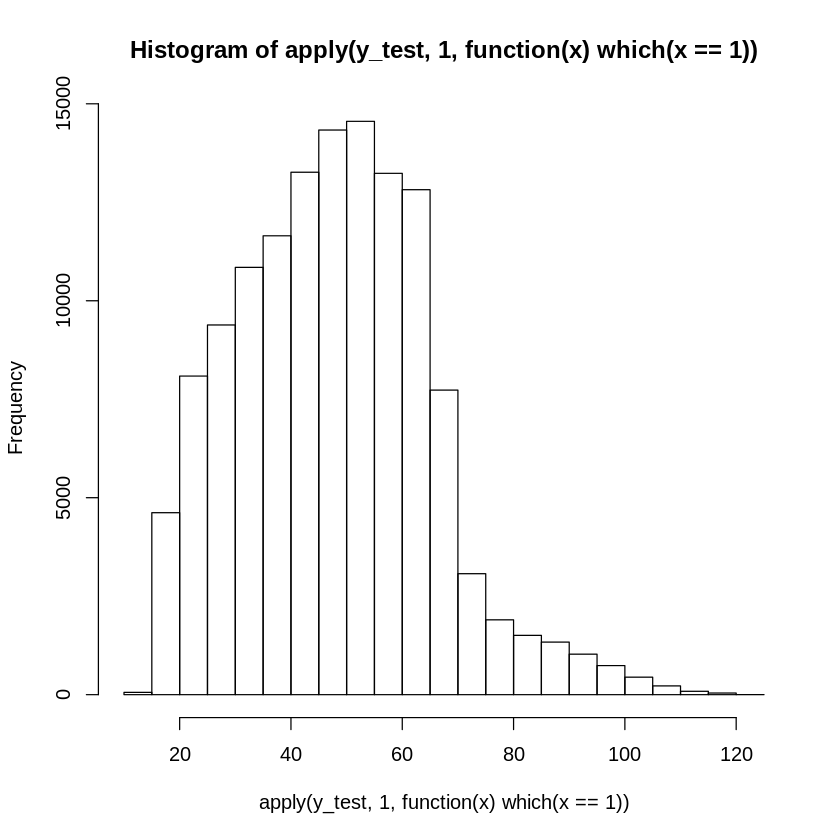

In [17]:
hist(apply(y_test,1,function(x) which(x==1)))
summary(df_all[ind_data, 614:614])
#stop()

### NN train

In [9]:
top_8_categorical_accuracy <-
  custom_metric("rec_at_8", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 8)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })

In [9]:
# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 5,
    filters = 8,
    depth_multiplier = 15,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%


layer_separable_conv_1d(
    kernel_size = 5,
    filters = 8,
    depth_multiplier = 15,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_8_categorical_accuracy
        )
)
summary(model) # Plot summary

# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 1000,
    batch_size =  250,
    validation_split = 0.2,
    shuffle = T,
    verbose = 2
  )



________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_1 (SeparableConv1D (None, 200, 8)                  593         
________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)      (None, 100, 8)                  0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 100, 8)                  0           
________________________________________________________________________________
batch_normalization_1 (BatchNormali (None, 100, 8)                  32          
________________________________________________________________________________
separable_conv1d_2 (SeparableConv1D (None, 96, 8)                   1568        
________________________________________________________________________________
max_pooling1d_2 (MaxPooling1

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): RuntimeError: No such namespace: reticulate.

Detailed traceback: 
  File "/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 204, in fit_loop
    callbacks.on_batch_end(batch_index, batch_logs)
  File "/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras/callbacks.py", line 115, in on_batch_end
    callback.on_batch_end(batch, logs)
  File "/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/R/library/keras/python/kerastools/callback.py", line 38, in on_batch_end
    self.r_on_batch_end(batch, logs)
  File "/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/R/library/reticulate/python/rpytools/call.py", line 21, in python_function
    raise RuntimeError(res[kErrorKey])



In [10]:
model <- load_model_hdf5(paste0("~/Downloads/model_dnu.h5"),
                        custom_objects = c(rec_at_8 = top_8_categorical_accuracy, 
                                           recat_6 = top_6_categorical_accuracy,
                                           rec_at_4 = top_4_categorical_accuracy,
                                           rec_at_2 = top_2_categorical_accuracy
                                          ))
#save_model_hdf5(model, paste0("~/Downloads/model_dr.h5"))
evaluate(model, x_test, y_test)

$loss
[1] 15.21055

$acc
[1] 0

$rec_at_2
[1] 0

$rec_at_4
[1] 7.635978e-06

$recat_6
[1] 7.635978e-06

$rec_at_8
[1] 7.635978e-06

In [11]:
plot(history) +
  theme_bw()

ERROR: Error in .External2(C_savehistory, file): no history available to save


### Confusion matrix

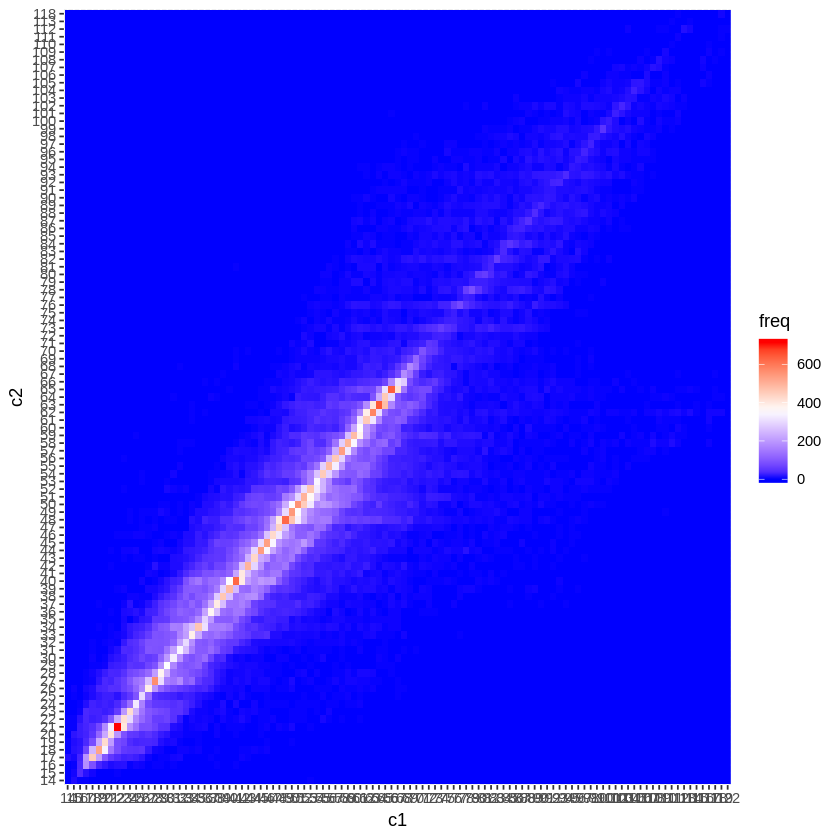

In [18]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

### MSE error acc_at_1

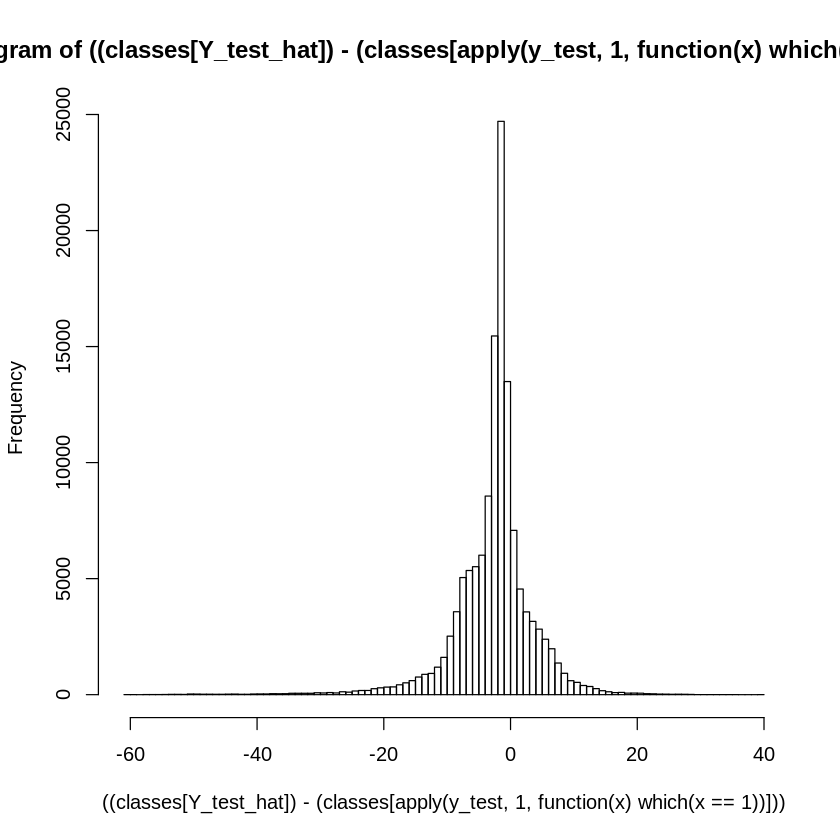

In [19]:
# Output dimension
classes <- seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )


hist(((classes[Y_test_hat]) - (classes[apply(y_test,1,function(x) which(x==1))])), breaks=100)

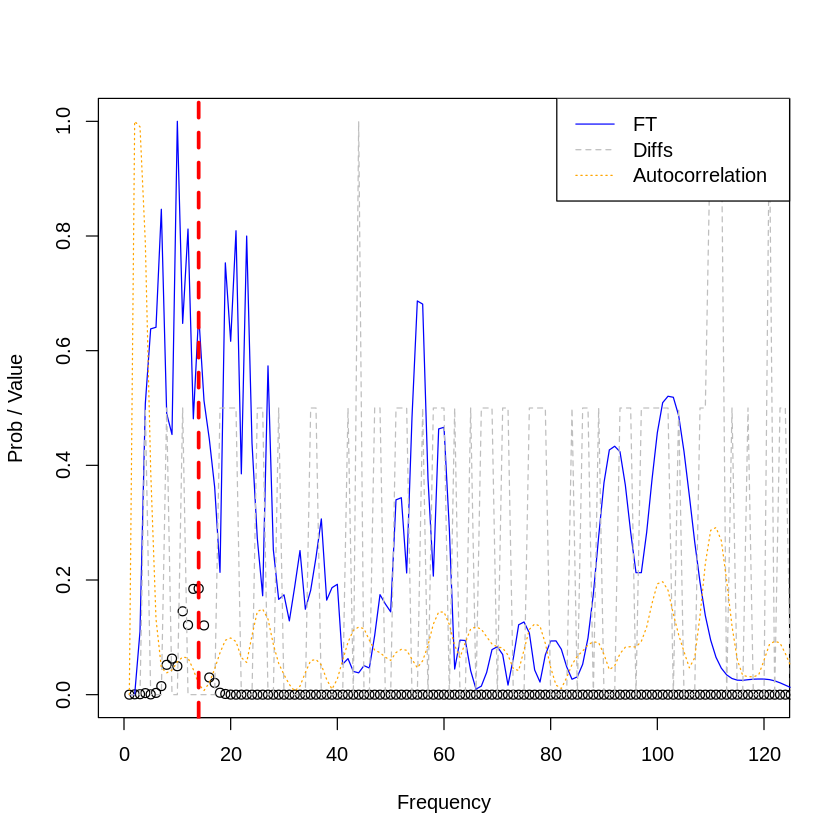

In [56]:
select_test <- 10009

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)

lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")


abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)

abline(
  v = which(y_test[select_test, ]==1)[2],
  col = "red",
  lwd = 3,
  lty = 2
)

legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange")
)